#Bibliotecas

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, log_loss
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
import pickle

from collections import defaultdict
import os
import random

from scipy.stats import spearmanr, pearsonr
from google.colab import files

# Random Seeds para reprodutibilidade
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

#Read and process the database
output_path = "/content/drive/MyDrive/Projeto Final - Introdução à Modelagem/Dataset/output/"
input_path = "/content/drive/MyDrive/Projeto Final - Introdução à Modelagem/Dataset/"

# Ensure the output directory exists before saving
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


#Dataset

In [3]:
data_assistments = pd.read_csv(input_path + "skill_builder_data.csv", encoding='latin1')
data_assistments.head()

/tmp/ipython-input-1949213948.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data_assistments = pd.read_csv(input_path + "skill_builder_data.csv", encoding='latin1')


,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,...,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original
0,33022537,277618,64525,33139,51424,1,1,1,32454,tutor,...,0,3,32454,30799,NaN,26,0,NaN,1,1.0
1,33022709,277618,64525,33150,51435,1,1,1,4922,tutor,...,0,3,4922,30799,NaN,55,0,NaN,2,2.0
2,35450204,220674,70363,33159,51444,1,0,2,25390,tutor,...,0,3,42000,30799,NaN,88,0,NaN,1,1.0
3,35450295,220674,70363,33110,51395,1,1,1,4859,tutor,...,0,3,4859,30059,NaN,41,0,NaN,2,2.0
4,35450311,220674,70363,33196,51481,1,0,14,19813,tutor,...,3,4,124564,30060,NaN,65,0,0.0,3,3.0


In [4]:
data_assistments.shape

(525534, 30)

In [5]:
print(data_assistments.columns.tolist())

['order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id', 'original', 'correct', 'attempt_count', 'ms_first_response', 'tutor_mode', 'answer_type', 'sequence_id', 'student_class_id', 'position', 'type', 'base_sequence_id', 'skill_id', 'skill_name', 'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time', 'template_id', 'answer_id', 'answer_text', 'first_action', 'bottom_hint', 'opportunity', 'opportunity_original']


In [6]:
num_distinct_users = data_assistments['user_id'].nunique()
print(f"Número de alunos distintos no dataset original: {num_distinct_users}")

Número de alunos distintos no dataset original: 4217


In [7]:
# Contagem de skills únicas ignorando nulos
print(data_assistments['skill_id'].nunique())

# Contagem de skills únicas incluindo nulos (NaN) como uma categoria
print(data_assistments['skill_id'].nunique(dropna=False))

num_distinct_skills = data_assistments['skill_id'].nunique()
print(f"Número de skills distintas no dataset original: {num_distinct_skills}")

123
124
Número de skills distintas no dataset original: 123


# Tratando o dataset

In [8]:
df=data_assistments.copy()

In [9]:
print('Null values in "correct" column:', data_assistments['correct'].isnull().sum())
print('Null values in "skill_id" column:', data_assistments['skill_id'].isnull().sum())
print('Null values in "user_id" column:', data_assistments['user_id'].isnull().sum())
print('Null values in "order_id" column:', data_assistments['order_id'].isnull().sum())

Null values in "correct" column: 0
Null values in "skill_id" column: 66326
Null values in "user_id" column: 0
Null values in "order_id" column: 0


In [10]:
# 1) Remover linhas com skill_id ou correct nulos
df_limpo = df.dropna(subset=['skill_id', 'correct'])

# 2) Manter apenas uma linha por (order_id, user_id)
df_final = df_limpo.drop_duplicates(
    subset=['order_id', 'user_id'],
    keep='first'   # pode trocar por 'last'
).reset_index(drop=True)

In [11]:
df_final["skill_id"] = df_final["skill_id"].astype(int)
df_final["correct"] = df_final["correct"].astype(int)

In [12]:
print(df.shape[0]-df_limpo.shape[0]) #linhas com skill_id nulo

print(df_limpo.shape[0]-df_final.shape[0]) #linhas multiskill removidas

66326
176103


In [13]:
df_final

,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,...,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original
0,33022537,277618,64525,33139,51424,1,1,1,32454,tutor,...,0,3,32454,30799,NaN,26,0,NaN,1,1.0
1,33022709,277618,64525,33150,51435,1,1,1,4922,tutor,...,0,3,4922,30799,NaN,55,0,NaN,2,2.0
2,35450204,220674,70363,33159,51444,1,0,2,25390,tutor,...,0,3,42000,30799,NaN,88,0,NaN,1,1.0
3,35450295,220674,70363,33110,51395,1,1,1,4859,tutor,...,0,3,4859,30059,NaN,41,0,NaN,2,2.0
4,35450311,220674,70363,33196,51481,1,0,14,19813,tutor,...,3,4,124564,30060,NaN,65,0,0.0,3,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283100,33150408,277900,85730,69042,128442,1,0,2,51016,tutor,...,0,4,102125,59998,NaN,3-Jul,0,NaN,13,13.0
283101,33150487,277900,85730,69056,128456,1,1,1,61547,tutor,...,0,4,61547,59998,NaN,2-May,0,NaN,14,14.0
283102,33150779,277900,85730,69046,128446,1,1,1,53890,tutor,...,0,4,53890,59998,NaN,10/-6,0,NaN,15,15.0
283103,33151098,277901,85730,69057,128457,1,0,4,181532,tutor,...,3,3,196844,60008,NaN,57/9,0,1.0,16,16.0


In [14]:
# Carregar o dataset
df = df_final[
    ["order_id", "user_id", "skill_id", "correct"]
]

df.shape

(283105, 4)

##Ordenando temporalmente

In [15]:
df = df.sort_values(by=["user_id", "order_id"])

In [16]:
num_distinct_users_df = df['user_id'].nunique()
print(f"Número de alunos distintos no df: {num_distinct_users_df}")

Número de alunos distintos no df: 4163


##Mapa de skill_id

In [17]:
#skills são conhecimento a priori (currículo fechado),
#então mapear aqui não causa vocabulary leakage/feature space contamination
skills = sorted(df["skill_id"].dropna().unique())
skill_map = {
    s: i for i, s in enumerate(skills)
    }

df["skill_idx"] = df["skill_id"].map(skill_map)
M = len(skill_map)
print(M)

112


##Sequências por aluno

In [18]:
student_sequences_raw = defaultdict(list)

for _, row in df.iterrows():
    student_sequences_raw[row["user_id"]].append(
        (row["skill_idx"], int(row["correct"]))
    )

# Lista com (user_id, sequence), para rastrear o user_id de cada sequência
student_sequences_with_ids = [(uid, seq) for uid, seq in student_sequences_raw.items()]

'''
Esperado agora:
[
  (user_id_1, [(q1, a1), (q2, a2), ...]),   # aluno 1
  (user_id_2, [(q1, a1), (q2, a2), ...]),   # aluno 2
  ...
]
'''

'\nEsperado agora:\n[\n  (user_id_1, [(q1, a1), (q2, a2), ...]),   # aluno 1\n  (user_id_2, [(q1, a1), (q2, a2), ...]),   # aluno 2\n  ...\n]\n'

In [19]:
print(f"Alunos: {len(student_sequences_raw)} | Habilidades: {M}")

Alunos: 4163 | Habilidades: 112


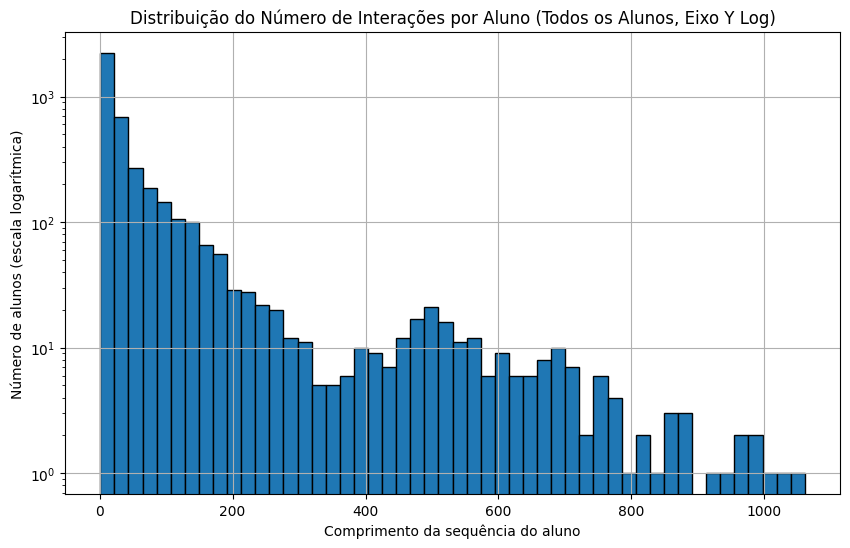

Total de alunos no dataset (antes de qualquer filtro por comprimento): 4163
Comprimento máximo da sequência: 1061
Comprimento mínimo da sequência: 1
Comprimento médio da sequência: 68.01
Comprimento mediano da sequência: 20.0


In [20]:
seq_lengths_all_students = [len(seq_data) for uid, seq_data in student_sequences_raw.items()]

plt.figure(figsize=(10, 6))
plt.hist(seq_lengths_all_students, bins=50, log=True, edgecolor='black')
plt.xlabel("Comprimento da sequência do aluno")
plt.ylabel("Número de alunos (escala logarítmica)")
plt.title("Distribuição do Número de Interações por Aluno (Todos os Alunos, Eixo Y Log)")
plt.grid(True)
plt.show()

print(f"Total de alunos no dataset (antes de qualquer filtro por comprimento): {len(seq_lengths_all_students)}")
print(f"Comprimento máximo da sequência: {max(seq_lengths_all_students)}")
print(f"Comprimento mínimo da sequência: {min(seq_lengths_all_students)}")
print(f"Comprimento médio da sequência: {np.mean(seq_lengths_all_students):.2f}")
print(f"Comprimento mediano da sequência: {np.median(seq_lengths_all_students)}")

In [21]:
# Convert to a Series for easier counting and cumulative calculations
seq_lengths_series = pd.Series(seq_lengths_all_students)

# Calculate counts for each length
length_counts = seq_lengths_series.value_counts().sort_index()

# Filter for lengths from 1 to 10
short_length_counts = length_counts[length_counts.index <= 10]

# Create a DataFrame for the summary
summary_df = pd.DataFrame({
    'Number of Interactions': short_length_counts.index,
    'Number of Students': short_length_counts.values
})

# Calculate cumulative sum and cumulative percentage
summary_df['Cumulative Students'] = summary_df['Number of Students'].cumsum()
summary_df['Cumulative Percentage'] = (summary_df['Cumulative Students'] / len(seq_lengths_all_students)) * 100

print("Detailed breakdown of students by interaction count (1 to 10):")
display(summary_df.round(2))

print("\n--- Analysis for potential thresholds ---")

# For threshold 3
students_below_3 = summary_df[summary_df['Number of Interactions'] < 3]['Number of Students'].sum()
percentage_below_3 = (students_below_3 / len(seq_lengths_all_students)) * 100
print(f"Students with less than 3 interactions: {students_below_3} ({percentage_below_3:.2f}% of total)")

# For threshold 5
students_below_5 = summary_df[summary_df['Number of Interactions'] < 5]['Number of Students'].sum()
percentage_below_5 = (students_below_5 / len(seq_lengths_all_students)) * 100
print(f"Students with less than 5 interactions: {students_below_5} ({percentage_below_5:.2f}% of total)")

print(f"\nTotal students: {len(seq_lengths_all_students)}")


Detailed breakdown of students by interaction count (1 to 10):


,Number of Interactions,Number of Students,Cumulative Students,Cumulative Percentage
0,1,136,136,3.27
1,2,175,311,7.47
2,3,103,414,9.94
3,4,105,519,12.47
4,5,166,685,16.45
5,6,127,812,19.51
6,7,123,935,22.46
7,8,137,1072,25.75
8,9,89,1161,27.89
9,10,159,1320,31.71



--- Analysis for potential thresholds ---
Students with less than 3 interactions: 311 (7.47% of total)
Students with less than 5 interactions: 519 (12.47% of total)

Total students: 4163


#Análise Exploratória

##Distribuição global de respostas (0 vs 1)

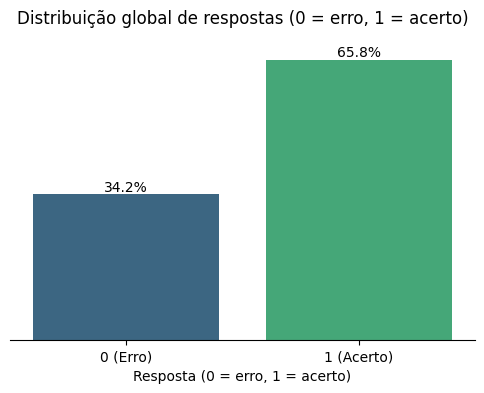

In [22]:
# Calculate proportions
proportions = df["correct"].value_counts(normalize=True).reset_index()
proportions.columns = ['correct', 'proportion']

# Create a seaborn bar plot
plt.figure(figsize=(6,4))
ax = sns.barplot(x='correct', y='proportion', hue='correct', data=proportions, palette='viridis', legend=False)
plt.title("Distribuição global de respostas (0 = erro, 1 = acerto)")
plt.xlabel("Resposta (0 = erro, 1 = acerto)")

# Remover o eixo Y e seu rótulo
ax.yaxis.set_visible(False)
plt.ylabel("") # Remover o label do eixo Y

# Ajustar o limite do eixo Y para que não haja espaço vazio excessivo
max_proportion = proportions['proportion'].max()
plt.ylim(0, max_proportion * 1.1) # 10% a mais que a proporção máxima para o texto

# Remover as bordas do gráfico
sns.despine(left=True, bottom=False, right=True, top=True) # Manter apenas a de baixo para os rótulos X

# Adicionar rótulos nas barras
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom') # Colocar o texto acima da barra

plt.xticks(ticks=[0, 1], labels=['0 (Erro)', '1 (Acerto)']) # Optional: make labels more descriptive

#plt.savefig(os.path.join(output_path, "balanceamentodasrespostas_seaborn_labeled_no_y.png"))
plt.show()

##Proporção de acertos por skill

In [23]:
skill_stats = (
    df.groupby("skill_idx")["correct"]
      .agg(["mean", "count"])
      .rename(columns={"mean": "acc_rate", "count": "n"})
)

skill_stats.head()

,acc_rate,n
skill_idx,,
0,0.753096,3957
1,0.523196,6208
2,0.710643,1804
3,0.594723,1895
4,0.869285,1859


##Histograma da taxa de acerto por skill

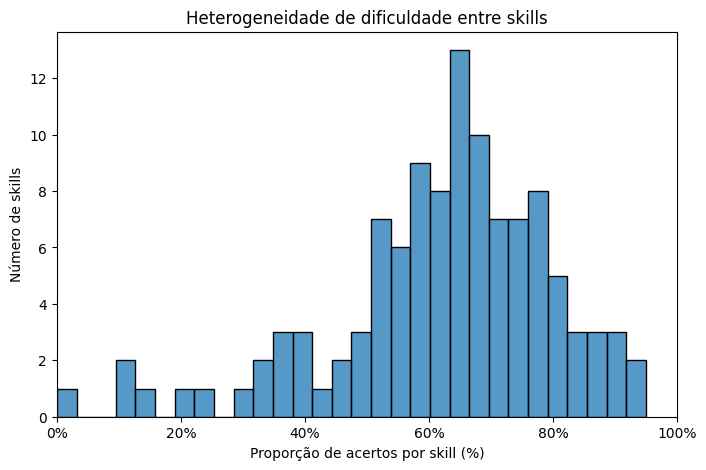

In [24]:
# Histogram da taxa de acerto por skill com Seaborn e eixo X em porcentagem
plt.figure(figsize=(8, 5))
sns.histplot(skill_stats["acc_rate"], bins=30, kde=False, stat="count") # Use stat="count" for count on y-axis and kde=False
plt.xlabel("Proporção de acertos por skill (%)")
plt.ylabel("Número de skills")
plt.title("Heterogeneidade de dificuldade entre skills")

# Formatar o eixo X para exibir porcentagens
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xlim(0, 1) # Ensure x-axis ranges from 0 to 1 (for percentages)

# Forçar o eixo Y a ter apenas ticks inteiros, já que representa contagens de skills
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

#plt.savefig(os.path.join(output_path, "histogramaacertoporskill_percentage_no_kde_integer_y.png"))
plt.show()

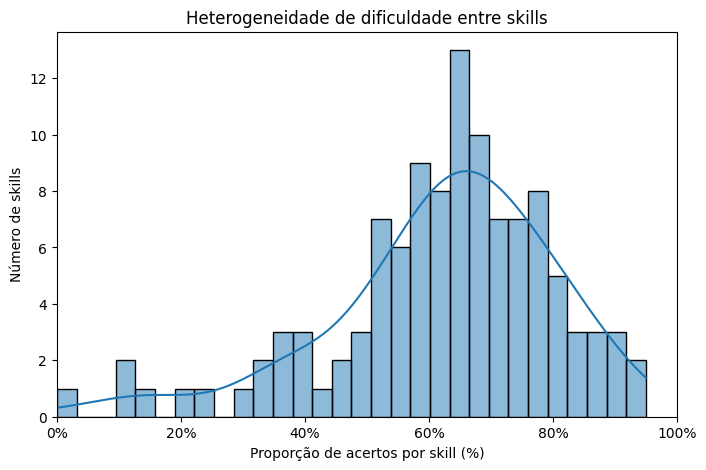

In [25]:
# Histogram da taxa de acerto por skill com Seaborn e eixo X em porcentagem
plt.figure(figsize=(8, 5))
sns.histplot(skill_stats["acc_rate"], bins=30, kde=True, stat="count") # Use stat="count" for count on y-axis
plt.xlabel("Proporção de acertos por skill (%)")
plt.ylabel("Número de skills")
plt.title("Heterogeneidade de dificuldade entre skills")

# Formatar o eixo X para exibir porcentagens
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xlim(0, 1) # Ensure x-axis ranges from 0 to 1 (for percentages)

#plt.savefig(os.path.join(output_path, "histogramaacertoporskill_percentage_kde.png"))
plt.show()

##Frequência por skill

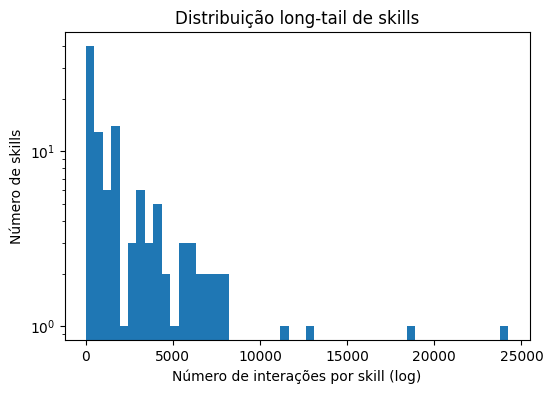

In [26]:
plt.figure(figsize=(6,4))
plt.hist(skill_stats["n"], bins=50, log=True)
plt.xlabel("Número de interações por skill (log)")
plt.ylabel("Número de skills")
plt.title("Distribuição long-tail de skills")
#plt.savefig(os.path.join(output_path, "frequenciaporskill.png"))
plt.show()

##Comprimento das sequências dos alunos

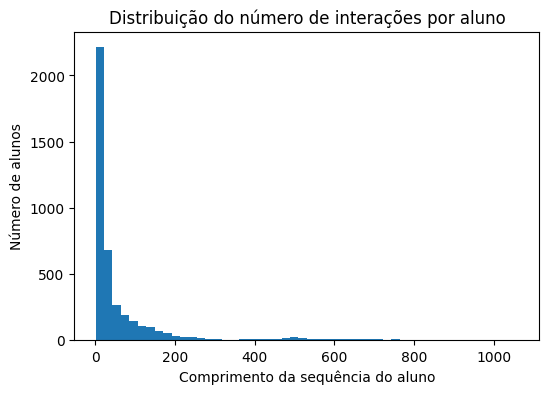

In [27]:
seq_lengths = [len(seq_data) for uid, seq_data in student_sequences_with_ids]

plt.figure(figsize=(6,4))
plt.hist(seq_lengths, bins=50)
plt.xlabel("Comprimento da sequência do aluno")
plt.ylabel("Número de alunos")
plt.title("Distribuição do número de interações por aluno")

# Save the plot to the output path
#plt.savefig(os.path.join(output_path, "sequence_length_histogram.png"))

plt.show()

Maximum sequence length: 1061


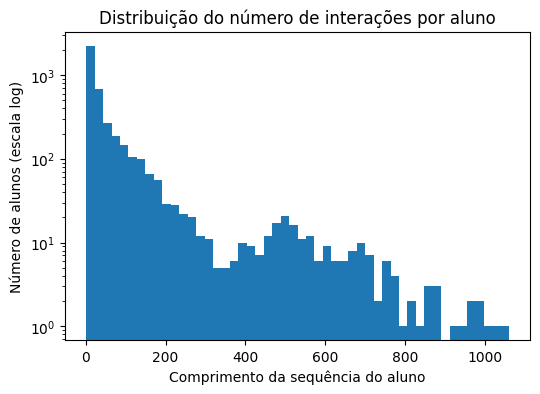

In [28]:
seq_lengths = [len(seq_data) for uid, seq_data in student_sequences_with_ids]

print(f"Maximum sequence length: {max(seq_lengths)}")

plt.figure(figsize=(6,4))
plt.hist(seq_lengths, bins=50)
plt.xlabel("Comprimento da sequência do aluno")
plt.ylabel("Número de alunos (escala log)") # Added log scale to label
plt.title("Distribuição do número de interações por aluno")
plt.yscale("log") # Added logarithmic scale to y-axis

# Save the plot to the output path
#plt.savefig(os.path.join(output_path, "sequence_length_histogram_log_scale.png"))

plt.show()

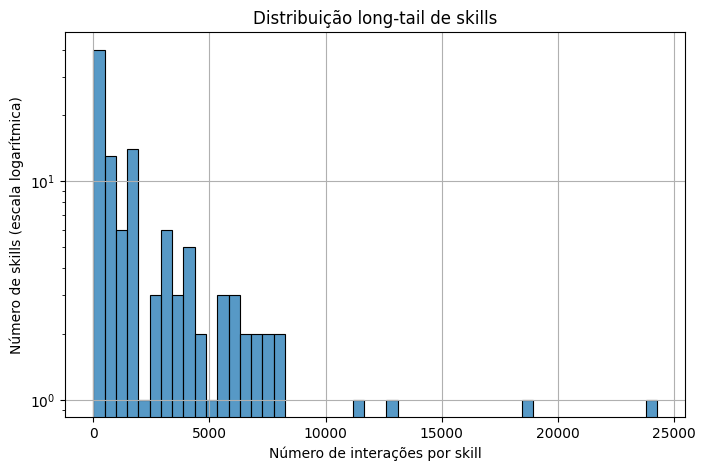

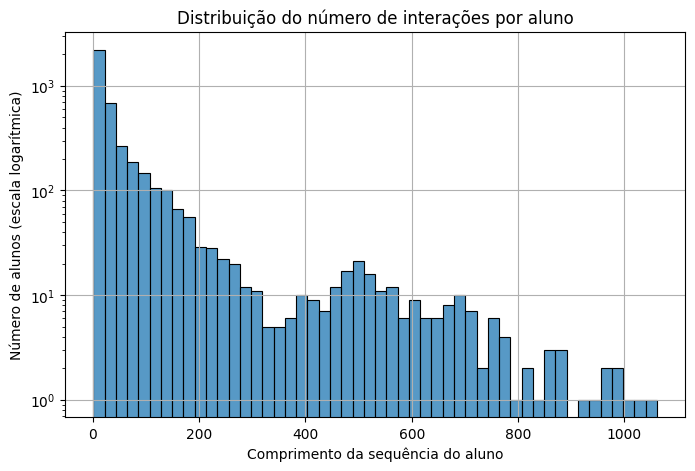

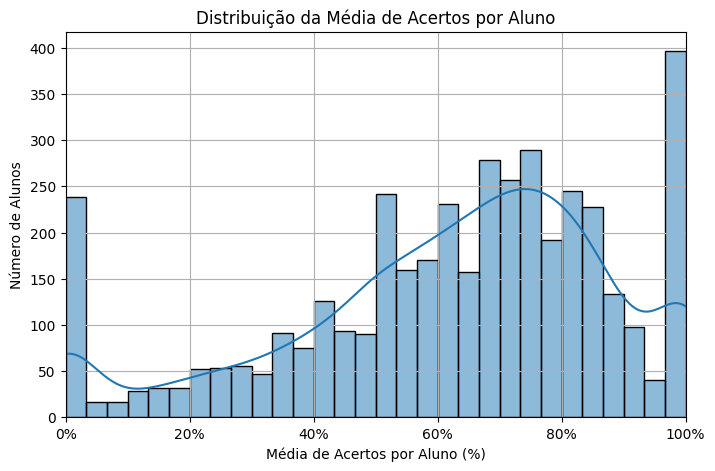

In [29]:
# --- 1. Distribuição long-tail de skills (Seaborn) ---
plt.figure(figsize=(8, 5))
# FIX: X linear e Y logarítmico para melhor visualização da long-tail
sns.histplot(skill_stats["n"], bins=50, kde=False) # X é linear por padrão
plt.xlabel("Número de interações por skill")
plt.ylabel("Número de skills (escala logarítmica)") # Ajustar label do Y
plt.title("Distribuição long-tail de skills")
plt.yscale("log") # Definir escala Y como logarítmica
plt.grid(True)
#plt.savefig(os.path.join(output_path, "frequenciaporskill_seaborn.png"))
plt.show()

# --- 2. Distribuição do número de interações por aluno (Seaborn) ---
# Ensure seq_lengths is available from previous cells (e.g., cell Zs13IWaDDh2f)
# seq_lengths = [len(seq_data) for uid, seq_data in student_sequences]
plt.figure(figsize=(8, 5))
sns.histplot(seq_lengths, bins=50, kde=False)
plt.xlabel("Comprimento da sequência do aluno")
plt.ylabel("Número de alunos (escala logarítmica)")
plt.title("Distribuição do número de interações por aluno")
plt.yscale("log")
plt.grid(True)
#plt.savefig(os.path.join(output_path, "sequence_length_histogram_seaborn_log_y.png"))
plt.show()

# --- 3. Distribuição da média de acertos por aluno (Seaborn, eixo X em percentual) ---
# Calculate average correctness for each student (moved from cell iSiu42QPDumZ)
average_correctness_per_student = []
for uid, seq in student_sequences_with_ids:
    if len(seq) > 0:
        correctness_scores = [answer for skill_idx, answer in seq]
        avg_correctness = np.mean(correctness_scores)
        average_correctness_per_student.append(avg_correctness)

plt.figure(figsize=(8, 5))
sns.histplot(np.array(average_correctness_per_student), bins=30, kde=True, stat="count")
plt.xlabel("Média de Acertos por Aluno (%)")
plt.ylabel("Número de Alunos")
plt.title("Distribuição da Média de Acertos por Aluno")

# Formatar o eixo X para exibir porcentagens
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xlim(0, 1) # Ensure x-axis ranges from 0 to 1 for percentages
plt.grid(True)
#plt.savefig(os.path.join(output_path, "avg_correctness_per_student_hist_percentage.png"))
plt.show()


#Divisão treino/teste

In [30]:
train_seqs, temp_seqs = train_test_split(
    student_sequences_with_ids, test_size=0.3, random_state=42
)

#Para validação
val_seqs, test_seqs = train_test_split(
    temp_seqs, test_size=0.5, random_state=42
)

In [31]:
#Removendo estudantes com poucas interacoes
def filter_short(seqs, min_len=5):
    return [(u,s) for (u,s) in seqs if len(s) >= min_len]

train_seqs = filter_short(train_seqs)
val_seqs   = filter_short(val_seqs)
test_seqs  = filter_short(test_seqs)

In [32]:
class DKTDataset(Dataset):
    def __init__(self, sequences, num_skills):
        """
        sequences: list of (user_id, [(q1,a1), (q2,a2), ...])
        """
        self.sequences = sequences
        self.M = num_skills

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        uid, seq = self.sequences[idx]
        T = len(seq)

        x = torch.zeros(T-1, 2 * self.M)
        q_next = torch.zeros(T-1, dtype=torch.long)
        a_next = torch.zeros(T-1)

        for t in range(T-1):
            #q_t, a_t = seq[t]
            #q_tp1, a_tp1 = seq[t+1]
            q_t, a_t = int(seq[t][0]), int(seq[t][1])
            q_tp1, a_tp1 = int(seq[t+1][0]), int(seq[t+1][1])

            x[t, q_t + a_t * self.M] = 1.0
            q_next[t] = q_tp1
            a_next[t] = a_tp1

        return x, q_next, a_next, uid # Return uid as well

#LSTM

##Célula

In [33]:
class LSTMCellScratch(nn.Module):
    def __init__(self, input_size, hidden_size, no_forget=False, no_input=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.no_forget = no_forget # Added
        self.no_input = no_input   # Added
        self.W = nn.Linear(input_size + hidden_size, 4 * hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        combined = torch.cat([x_t, h_prev], dim=1)
        gates = self.W(combined)

        i, f, g, o = gates.chunk(4, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        # ===== ABLATIONS =====
        if self.no_forget:
            f = torch.ones_like(f)      # nunca esquece

        if self.no_input:
            i = torch.ones_like(i)      # sempre incorpora entrada
        # ====================

        c_t = f * c_prev + i * g
        h_t = o * torch.tanh(c_t)

        return h_t, c_t, f, i, o, g

##LSTM Temporal

In [34]:
class LSTMScratch(nn.Module):
    def __init__(self, input_size, hidden_size, no_forget=False, no_input=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = LSTMCellScratch(
            input_size, hidden_size,
            no_forget=no_forget,
            no_input=no_input
        )

    def forward(self, x, return_gates=False):
        B, T, _ = x.size()
        h = torch.zeros(B, self.hidden_size, device=x.device)
        c = torch.zeros(B, self.hidden_size, device=x.device)

        outputs = []

        if return_gates:
            f_seq, i_seq, o_seq, g_seq, c_seq, h_seq = [], [], [], [], [], []

        for t in range(T):
            h, c, f, i, o, g = self.cell(x[:, t], h, c)
            outputs.append(h.unsqueeze(1))

            if return_gates:
                f_seq.append(f)
                i_seq.append(i)
                o_seq.append(o)
                g_seq.append(g)
                c_seq.append(c)
                h_seq.append(h)

        if return_gates:
            return (
                torch.cat(outputs, dim=1),
                torch.stack(f_seq, dim=1),
                torch.stack(i_seq, dim=1),
                torch.stack(o_seq, dim=1),
                torch.stack(g_seq, dim=1),
                torch.stack(c_seq, dim=1),
                torch.stack(h_seq, dim=1),
            )

        return torch.cat(outputs, dim=1)

#Para lidar no batch com sequências de tamanhos diferentes

In [35]:
def dkt_collate(batch):
    """
    batch: list of (x, q_next, a_next, uid)
    """
    batch_size = len(batch)
    max_len = max(item[0].size(0) for item in batch)
    input_dim = batch[0][0].size(1)

    x_pad = torch.zeros(batch_size, max_len, input_dim)
    q_pad = torch.zeros(batch_size, max_len, dtype=torch.long)
    a_pad = torch.zeros(batch_size, max_len)
    mask  = torch.zeros(batch_size, max_len)
    uids  = [] # Collect uids

    for i, (x, q, a, uid) in enumerate(batch): # Unpack uid
        L = x.size(0)
        x_pad[i, :L] = x
        q_pad[i, :L] = q
        a_pad[i, :L] = a
        mask[i, :L] = 1.0
        uids.append(uid)

    return x_pad, q_pad, a_pad, mask, uids # Return uids

##Dataloaders

In [36]:
train_dataset = DKTDataset(train_seqs, M)
test_dataset  = DKTDataset(test_seqs,  M)
val_dataset   = DKTDataset(val_seqs,   M)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=dkt_collate)
test_loader  = DataLoader(test_dataset,  batch_size=32, collate_fn=dkt_collate)
val_loader   = DataLoader(val_dataset,   batch_size=32, collate_fn=dkt_collate)

In [37]:
x, q, a, m, uids = next(iter(train_loader))
print(x.shape, q.shape, a.shape, m.shape, uids)

torch.Size([32, 521, 224]) torch.Size([32, 521]) torch.Size([32, 521]) torch.Size([32, 521]) [np.int64(85643), np.int64(78568), np.int64(87150), np.int64(80950), np.int64(89985), np.int64(89446), np.int64(80213), np.int64(88150), np.int64(88737), np.int64(78783), np.int64(87540), np.int64(91114), np.int64(87430), np.int64(84750), np.int64(71193), np.int64(83871), np.int64(78207), np.int64(88182), np.int64(79068), np.int64(80637), np.int64(84078), np.int64(88777), np.int64(88129), np.int64(91414), np.int64(78877), np.int64(82316), np.int64(83190), np.int64(78509), np.int64(85029), np.int64(78447), np.int64(88917), np.int64(82482)]


In [38]:
batch = next(iter(train_loader))
len(batch)

5

In [39]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 2558
Validation dataset size: 541
Test dataset size: 545


#DKT

In [40]:
class DKT(nn.Module):
    def __init__(self, num_skills, hidden_size=200, no_forget=False, no_input=False, dropout_rate=0.5):
        super().__init__()
        self.M = num_skills
        # Pass no_forget and no_input to LSTMScratch
        self.lstm = LSTMScratch(2 * num_skills, hidden_size, no_forget=no_forget, no_input=no_input)
        # Use dropout_rate passed to the constructor
        self.dropout = nn.Dropout(dropout_rate)
        # Remove no_forget and no_input from nn.Linear
        self.fc = nn.Linear(hidden_size, num_skills)

    def forward(self, x):
        h_seq = self.lstm(x)
        #h_seq, _ = self.lstm(x)
        h_seq = self.dropout(h_seq)
        y = torch.sigmoid(self.fc(h_seq))
        return y, h_seq

##Loss

In [41]:
def dkt_loss(y, q_next, a_next, mask):
    # y: (B, T, M)
    pred = y.gather(2, q_next.unsqueeze(-1)).squeeze(-1)
    loss = F.binary_cross_entropy(pred, a_next, reduction="none")
    return (loss * mask).sum()

##Avaliação

In [42]:
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for x, q_next, a_next, mask, _ in loader:
            x = x.to(device)
            q_next = q_next.to(device)

            y, _ = model(x)
            p = y.gather(2, q_next.unsqueeze(-1)).squeeze(-1)

            preds.append(p[mask.bool()].cpu().numpy())
            targets.append(a_next[mask.bool()].numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    return {
        "AUC": roc_auc_score(targets, preds),
        "RMSE": np.sqrt(mean_squared_error(targets, preds)),
        "LogLoss": log_loss(targets, preds)
    }

##Treino com early stopping

In [43]:
def grad_norm(model):
    total = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total += p.grad.data.norm(2).item() ** 2
    return total ** 0.5


def train_dkt_early_stopping(
    model,
    train_loader,
    val_loader,
    test_loader,
    epochs=100,
    lr=1e-3,
    patience=5,
    min_delta=1e-4
):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_auc = -np.inf
    best_state = None
    patience_counter = 0

    history = {
        "train_loss": [],
        "val_auc": [],
        "test_auc": []
    }

    grad_history = []   # <<< gradiente MÉDIO por epoch

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        grad_epoch = []   # <<< acumula gradientes desta epoch

        for x, q, a, mask, _ in train_loader:
            x = x.to(device)
            q = q.to(device)
            a = a.to(device)
            mask = mask.to(device)

            y, _ = model(x)
            loss = dkt_loss(y, q, a, mask)

            optimizer.zero_grad()
            loss.backward()

            gn = grad_norm(model)
            grad_epoch.append(gn)   # <<< agora é por batch (temporário)

            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            total_loss += loss.item()

        # <<< ao final da epoch, guarda a média
        grad_history.append(np.mean(grad_epoch))

        val_metrics = evaluate(model, val_loader)
        test_metrics = evaluate(model, test_loader)

        val_auc = val_metrics["AUC"]
        test_auc = test_metrics["AUC"]


        history["train_loss"].append(total_loss)
        history["val_auc"].append(val_auc)
        history["test_auc"].append(test_auc)

        print(
            f"Epoch {epoch:02d} | "
            f"Train Loss {total_loss:.1f} | "
            f"Val AUC {val_auc:.4f} | "
            f"Test AUC {test_auc:.4f}"
        )

        # Early stopping
        if val_auc > best_val_auc + min_delta:
            best_val_auc = val_auc
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"  No improvement ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history, grad_history   # <<< retorna grad_history também

##Funções de análise

In [44]:
'''def analyze_dkt(model, loader, device):
    model.eval()

    all_stats = []

    with torch.no_grad():
        for x, q, a, mask, _ in loader:
            x = x.to(device)

            # Unpack all 6 values returned by LSTMScratch when return_gates=True
            h_seq_main, f_seq, i_seq, o_seq, c_seq, h_seq_final = model.lstm(x, return_gates=True)

            # f_seq, c_seq: (B, T, H)

            f_mean_t = f_seq.mean(dim=2)      # (B, T)
            c_norm_t = torch.norm(c_seq, dim=2)  # (B, T)

            for b in range(x.size(0)):
                # Ensure we only consider actual sequence length
                actual_len = mask[b].sum().int().item()
                if actual_len > 0: # Only process if sequence is not empty
                    stats = {
                        "f_mean": f_mean_t[b, :actual_len].mean().item(), # Mean across actual length
                        "f_p10":  torch.quantile(f_mean_t[b, :actual_len], 0.1).item(),
                        "f_p90":  torch.quantile(f_mean_t[b, :actual_len], 0.9).item(),
                        "c_avg":  c_norm_t[b, :actual_len].mean().item(), # Mean across actual length
                        "seq_len": actual_len
                    }
                    all_stats.append(stats)

    return all_stats'''

'def analyze_dkt(model, loader, device):\n    model.eval()\n\n    all_stats = []\n\n    with torch.no_grad():\n        for x, q, a, mask, _ in loader:\n            x = x.to(device)\n\n            # Unpack all 6 values returned by LSTMScratch when return_gates=True\n            h_seq_main, f_seq, i_seq, o_seq, c_seq, h_seq_final = model.lstm(x, return_gates=True)\n\n            # f_seq, c_seq: (B, T, H)\n\n            f_mean_t = f_seq.mean(dim=2)      # (B, T)\n            c_norm_t = torch.norm(c_seq, dim=2)  # (B, T)\n\n            for b in range(x.size(0)):\n                # Ensure we only consider actual sequence length\n                actual_len = mask[b].sum().int().item()\n                if actual_len > 0: # Only process if sequence is not empty\n                    stats = {\n                        "f_mean": f_mean_t[b, :actual_len].mean().item(), # Mean across actual length\n                        "f_p10":  torch.quantile(f_mean_t[b, :actual_len], 0.1).item(),\n            

In [45]:
def analyze_dkt(model, loader, device):
    model.eval()
    all_stats = []

    with torch.no_grad():
        for x, q, a, mask, _ in loader:
            x = x.to(device)

            (
                h_seq,
                f_seq,
                i_seq,
                o_seq,
                g_seq,
                c_seq,
                _
            ) = model.lstm(x, return_gates=True)

            f_mean_t = f_seq.mean(dim=2)
            c_norm_t = torch.norm(c_seq, dim=2)

            for b in range(x.size(0)):
                actual_len = mask[b].sum().int().item()
                if actual_len == 0:
                    continue

                all_stats.append({
                    "f_mean": f_mean_t[b, :actual_len].mean().item(),
                    "f_p10": torch.quantile(f_mean_t[b, :actual_len], 0.1).item(),
                    "f_p90": torch.quantile(f_mean_t[b, :actual_len], 0.9).item(),
                    "c_avg": c_norm_t[b, :actual_len].mean().item(),
                    "seq_len": actual_len
                })

    return all_stats

#Carregando hiperparâmetros

In [46]:
best_config_filepath = os.path.join(output_path, "best_config.pkl")

# Load the best_cfg dictionary using pickle
with open(best_config_filepath, "rb") as f:
    best_cfg = pickle.load(f)

print("Loaded best config:", best_cfg)

Loaded best config: {'hidden': 200, 'dropout': 0.5, 'lr': 0.001, 'best_val_auc': np.float64(0.754365688641788)}


#*Experimentos*
NÃO RODAR DE NOVO, MODELOS JÁ SALVOS

##Experimento 1

In [ ]:
model_dkt = DKT(M, hidden_size=200)
history_dkt = train_dkt_early_stopping(
    model_dkt,
    train_loader,
    val_loader,
    test_loader,
    epochs=50,
    patience=5
)

Epoch 01 | Train Loss 125683.0 | Val AUC 0.6685 | Test AUC 0.6816
Epoch 02 | Train Loss 118897.1 | Val AUC 0.7150 | Test AUC 0.7223
Epoch 03 | Train Loss 114525.2 | Val AUC 0.7289 | Test AUC 0.7347
Epoch 04 | Train Loss 112776.3 | Val AUC 0.7315 | Test AUC 0.7387
Epoch 05 | Train Loss 111626.0 | Val AUC 0.7377 | Test AUC 0.7445
Epoch 06 | Train Loss 110955.8 | Val AUC 0.7410 | Test AUC 0.7470


In [ ]:
# Save model
torch.save(model_dkt.state_dict(), "model_dkt_modelagem.pt")
print("Model saved: model_dkt_modelagem.pt")

# Save history_dkt
try:
    if history_dkt is not None and isinstance(history_dkt, tuple) and len(history_dkt) == 2:
        with open("history_dkt.pkl", "wb") as f:
            pickle.dump(history_dkt, f)
        print("History saved: history_dkt.pkl")
    else:
        print("Warning: history_dkt exists but is empty or invalid.")
except NameError:
    print("Warning: history_dkt is not defined. Run Experimento 1 first.")'''

Model saved: model_perf_dkt_final.pt
History saved: history_perf.pkl


#Treino completo com Train+Val
Não rodar de novo

In [ ]:
history_perf_path = os.path.join(input_path, "history_perf.pkl")
try:
    with open(history_perf_path, 'rb') as f:
        history_perf = pickle.load(f)
    print(f"History for model_perf loaded successfully from: {history_perf_path}")
except FileNotFoundError:
    print(f"Warning: History file not found for model_perf at: {history_perf_path}. Please ensure it was saved previously or run 'Experimento 1' (cell 86c0b5b6) to generate and save it.")
    history_perf = None # Set to None if not found
except EOFError:
    print(f"Warning: History file for model_perf at: {history_perf_path} is empty or corrupted. Please ensure 'Experimento 1' (cell 86c0b5b6) was run and saved correctly.")
    history_perf = None

History for model_perf loaded successfully from: /content/drive/MyDrive/Projeto de Deep learning - LSTM/Dataset/history_perf.pkl


In [ ]:
# Get epochs_ran from the loaded history_perf
if 'history_perf' in locals() and history_perf is not None:
    best_cfg['epochs_ran'] = len(history_perf[0]["val_auc"])
else:
    print("Warning: history_perf not found or invalid. Setting epochs_ran to a default of 33.")
    best_cfg['epochs_ran'] = 33 # Fallback in case history_perf is not available

print("Best config:", best_cfg)

Best config: {'hidden': 200, 'dropout': 0.5, 'lr': 0.001, 'best_val_auc': np.float64(0.754365688641788), 'epochs_ran': 31}


In [ ]:
def train_dkt_final(
    model,
    train_loader,
    epochs,
    lr=1e-3
):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "grad_norm": []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        grad_epoch = []

        for x, q, a, mask, _ in train_loader:
            x = x.to(device)
            q = q.to(device)
            a = a.to(device)
            mask = mask.to(device)

            y, _ = model(x)
            loss = dkt_loss(y, q, a, mask)

            optimizer.zero_grad()
            loss.backward()

            # grad norm
            gn = grad_norm(model)
            grad_epoch.append(gn)

            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            total_loss += loss.item()

        history["train_loss"].append(total_loss)
        history["grad_norm"].append(np.mean(grad_epoch))

        print(
            f"Epoch {epoch:02d} | "
            f"Train Loss {total_loss:.2f} | "
            f"GradNorm {np.mean(grad_epoch):.4f}"
        )

    return history

In [ ]:
#Dataset final
final_train_seqs = train_seqs + val_seqs
final_train_dataset = DKTDataset(final_train_seqs, M)
final_train_loader = DataLoader(
    final_train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=dkt_collate
)

In [ ]:
final_model = DKT(
    num_skills=M,
    hidden_size=best_cfg["hidden"],
    dropout_rate=best_cfg["dropout"]
).to(device)

In [ ]:
final_history = train_dkt_final(
    final_model,
    final_train_loader,
    epochs=best_cfg["epochs_ran"],
    lr=best_cfg["lr"]
)


Epoch 01 | Train Loss 151441.10 | GradNorm 236.8591
Epoch 02 | Train Loss 140585.33 | GradNorm 563.9059
Epoch 03 | Train Loss 137240.74 | GradNorm 470.4192
Epoch 04 | Train Loss 134309.18 | GradNorm 281.4821
Epoch 05 | Train Loss 132907.60 | GradNorm 286.7894
Epoch 06 | Train Loss 132406.87 | GradNorm 308.2550
Epoch 07 | Train Loss 131841.75 | GradNorm 271.7343
Epoch 08 | Train Loss 131302.94 | GradNorm 230.7243
Epoch 09 | Train Loss 130731.19 | GradNorm 235.7898
Epoch 10 | Train Loss 130414.46 | GradNorm 244.4234
Epoch 11 | Train Loss 130336.13 | GradNorm 251.9091
Epoch 12 | Train Loss 129848.87 | GradNorm 219.0482
Epoch 13 | Train Loss 129802.63 | GradNorm 239.1420
Epoch 14 | Train Loss 129229.91 | GradNorm 210.6832
Epoch 15 | Train Loss 129078.64 | GradNorm 226.2359
Epoch 16 | Train Loss 128660.81 | GradNorm 267.6146
Epoch 17 | Train Loss 128414.06 | GradNorm 224.9875
Epoch 18 | Train Loss 128322.60 | GradNorm 242.9176
Epoch 19 | Train Loss 127882.90 | GradNorm 233.1563
Epoch 20 | T

In [ ]:
final_test_metrics = evaluate(final_model, test_loader)

print("\n--- FINAL TEST PERFORMANCE ---")
print(f"AUC:     {final_test_metrics['AUC']:.4f}")
print(f"RMSE:    {final_test_metrics['RMSE']:.4f}")
print(f"LogLoss: {final_test_metrics['LogLoss']:.4f}")


--- FINAL TEST PERFORMANCE ---
AUC:     0.7584
RMSE:    0.4231
LogLoss: 0.5358


In [ ]:
torch.save(
    final_model.state_dict(),
    os.path.join(output_path, "final_dkt_model.pt")
)

with open(os.path.join(output_path, "final_dkt_history.pkl"), "wb") as f:
    pickle.dump(
        {
            "history": final_history,
            "best_cfg": best_cfg,
            "test_metrics": final_test_metrics
        },
        f
    )

#Carregando modelo completo salvo

In [47]:
#Instantiate and load model_perf
model_perf = DKT(M, hidden_size=200)
model_perf_path = os.path.join(output_path, "final_dkt_model.pt")
model_perf.load_state_dict(torch.load(model_perf_path, map_location=device))
model_perf.eval()

print("Model_perf loaded successfully and set to eval mode.")

Model_perf loaded successfully and set to eval mode.


In [48]:
# Load history for model_perf
history_perf_path = os.path.join(output_path, "final_dkt_history.pkl")
try:
    with open(history_perf_path, 'rb') as f:
        history_perf = pickle.load(f)
    print(f"History for model_perf loaded successfully from: {history_perf_path}")
except FileNotFoundError:
    print(f"Warning: History file not found for model_perf at: {history_perf_path}. Please ensure it was saved previously or run 'Experimento 1' (cell 86c0b5b6) to generate and save it.")
    history_perf = None # Set to None if not found
except EOFError:
    print(f"Warning: History file for model_perf at: {history_perf_path} is empty or corrupted. Please ensure 'Experimento 1' (cell 86c0b5b6) was run and saved correctly.")
    history_perf = None

History for model_perf loaded successfully from: /content/drive/MyDrive/Projeto Final - Introdução à Modelagem/Dataset/output/final_dkt_history.pkl


#Avaliando a qualidade do forecast

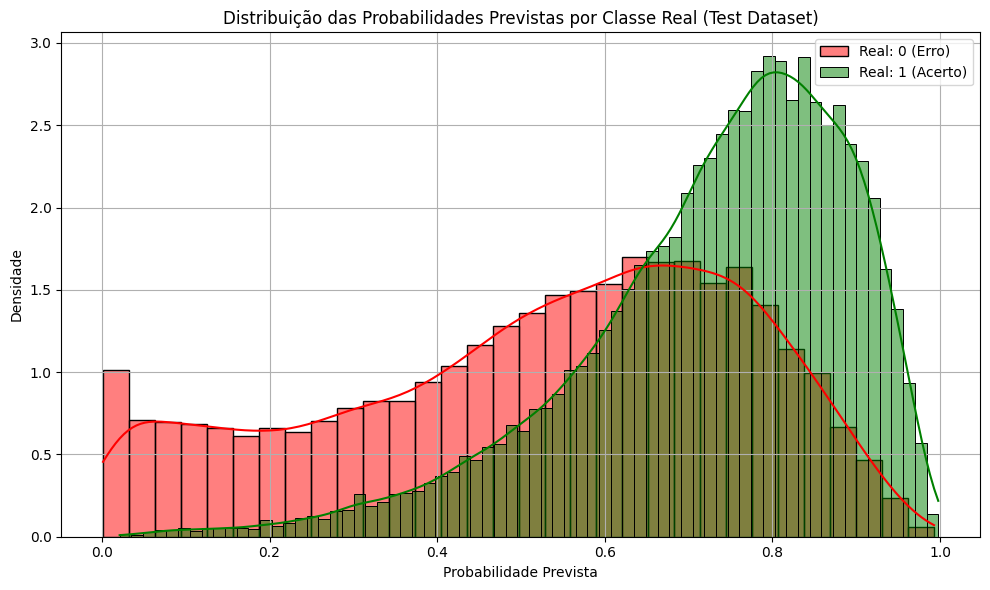

In [49]:
# Ensure model_perf is in evaluation mode and on the correct device
model_perf.eval()
model_perf.to(device)

all_preds = []
all_targets = []

# Collect all predictions and true labels from the test_loader
with torch.no_grad():
    for x, q_next, a_next, mask, _ in test_loader: # Assuming test_loader yields 5 values including uids
        x = x.to(device)
        q_next = q_next.to(device)
        a_next = a_next.to(device)
        mask = mask.to(device)

        y, _ = model_perf(x) # model_perf returns y, h_seq
        p = y.gather(2, q_next.unsqueeze(-1)).squeeze(-1) # Predicted probability for the actual next question

        all_preds.append(p[mask.bool()].cpu().numpy())
        all_targets.append(a_next[mask.bool()].cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# --- Plot: Distribution of Predicted Probabilities by True Class ---
plt.figure(figsize=(10, 6))
sns.histplot(all_preds[all_targets == 0], color='red', label='Real: 0 (Erro)', kde=True, stat='density', alpha=0.5)
sns.histplot(all_preds[all_targets == 1], color='green', label='Real: 1 (Acerto)', kde=True, stat='density', alpha=0.5)
plt.xlabel("Probabilidade Prevista")
plt.ylabel("Densidade")
plt.title("Distribuição das Probabilidades Previstas por Classe Real (Test Dataset)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


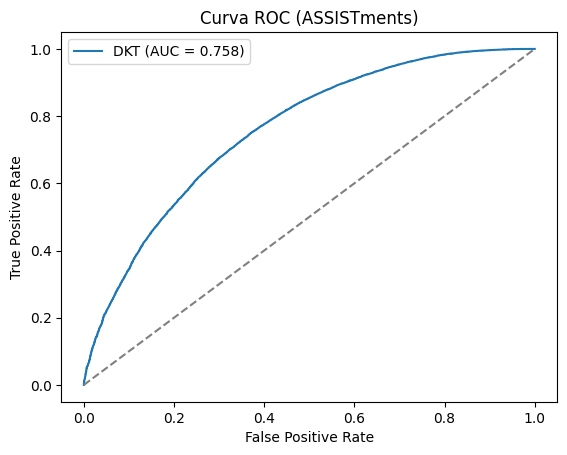

Arrays y_true and y_pred saved to /content/drive/MyDrive/Projeto Final - Introdução à Modelagem/Dataset/output/roc_data.npz


In [50]:
model_perf.eval()

y_true_dkt = []
y_pred_dkt = []

with torch.no_grad():
    for x_batch, q_next, a_next, mask, _ in test_loader: # Added '_' to unpack the 5th value (uids)
        preds = model_perf(x_batch)[0] # model_perf returns (y, h_seq), we need y

        # seleciona probabilidade prevista do exercício respondido
        # Filter to only valid (non-padded) predictions
        valid_timesteps_mask = mask.bool()

        # Reshape q_next for gather operation
        q_next_reshaped = q_next.unsqueeze(-1)

        # Gather predictions for the next question, then squeeze to remove last dimension
        p = preds.gather(2, q_next_reshaped).squeeze(-1)

        # Filter out padded predictions and true labels
        y_pred_dkt.extend(p[valid_timesteps_mask].cpu().numpy())
        y_true_dkt.extend(a_next[valid_timesteps_mask].cpu().numpy())


fpr_dkt, tpr_dkt, _ = roc_curve(y_true_dkt, y_pred_dkt)
roc_auc_dkt = auc(fpr_dkt, tpr_dkt)

plt.plot(fpr_dkt, tpr_dkt, label=f"DKT (AUC = {roc_auc_dkt:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (ASSISTments)")
plt.legend()
plt.show()

# --- Save y_true and y_pred ---
save_path = os.path.join(output_path, 'roc_data.npz')
np.savez_compressed(save_path, y_true=y_true_dkt, y_pred=y_pred_dkt)
print(f"Arrays y_true and y_pred saved to {save_path}")

# Métricas


In [51]:
# Ensure model_perf is in evaluation mode and on the correct device
model_perf.eval()
model_perf.to(device)

student_roc_aucs = []
student_rmses = []
student_brier_scores = [] # New: list for Brier Scores

print("Calculating ROC AUC, RMSE, and Brier Score for each student...")

# Iterate through all student sequences in the dataset
for original_seq_idx, (user_id, seq) in enumerate(student_sequences_with_ids):
    # DKTDataset expects T-1, so original sequence must be at least 2
    if len(seq) < 2:
        # print(f"Skipping student {user_id} due to short sequence length: {len(seq)}")
        continue

    # Prepare data for this single student
    # FIX 1: Pass (user_id, seq) as a tuple within the list to DKTDataset
    single_student_dataset = DKTDataset([(user_id, seq)], M)
    # FIX 2: DKTDataset.__getitem__ returns 4 values (x, q_next, a_next, uid)
    x_single, q_next_single, a_next_single, _ = single_student_dataset[0]

    # dkt_collate expects a list of (x, q_next, a_next, uid) tuples
    # FIX 3: dkt_collate returns 5 values (x_pad, q_pad, a_pad, mask, uids)
    x_padded, q_next_padded, a_next_padded, mask_padded, _ = dkt_collate([(x_single, q_next_single, a_next_single, user_id)])

    x_padded = x_padded.to(device);
    q_next_padded = q_next_padded.to(device);
    a_next_padded = a_next_padded.to(device);
    mask_padded = mask_padded.to(device);

    with torch.no_grad():
        y_perf, _ = model_perf(x_padded) # y_perf: (B=1, T, M)

    # Extract predicted probabilities for the specific questions answered
    p_t_perf = y_perf.gather(2, q_next_padded.unsqueeze(-1)).squeeze(-1)

    # Convert to numpy for metric calculation and filter out padded values
    valid_timesteps_mask = mask_padded.squeeze(0).bool().cpu().numpy()
    predicted_probs_filtered = p_t_perf.squeeze(0).cpu().numpy()[valid_timesteps_mask]
    actual_correctness_filtered = a_next_padded.squeeze(0).cpu().numpy()[valid_timesteps_mask]

    # Calculate ROC AUC
    if len(np.unique(actual_correctness_filtered)) > 1: # ROC AUC requires at least two classes
        student_roc_aucs.append(roc_auc_score(actual_correctness_filtered, predicted_probs_filtered))
    else:
        # print(f"  Skipping ROC AUC for student {user_id} (only one class in true labels).")
        student_roc_aucs.append(np.nan) # Append NaN if ROC AUC cannot be computed

    # Calculate RMSE
    student_rmses.append(np.sqrt(mean_squared_error(actual_correctness_filtered, predicted_probs_filtered)))

    # New: Calculate Brier Score
    student_brier_scores.append(mean_squared_error(actual_correctness_filtered, predicted_probs_filtered)) # Brier Score is just MSE between probabilities and binary outcomes

print(f"Finished calculating metrics for {len(student_roc_aucs)} students.")

# Convert to numpy arrays for easier analysis
student_roc_aucs = np.array(student_roc_aucs)
student_rmses = np.array(student_rmses)
student_brier_scores = np.array(student_brier_scores)

# Filter out NaNs for statistical summaries where appropriate
valid_roc_aucs = student_roc_aucs[~np.isnan(student_roc_aucs)]

print("\n--- Summary Statistics (Model_perf) ---")
print(f"ROC AUC (Mean): {np.mean(valid_roc_aucs):.4f}")
print(f"ROC AUC (Std):  {np.std(valid_roc_aucs):.4f}")
print(f"ROC AUC (Min):  {np.min(valid_roc_aucs):.4f}")
print(f"ROC AUC (Max):  {np.max(valid_roc_aucs):.4f}")
print(f"Number of students with valid ROC AUC: {len(valid_roc_aucs)}")

print(f"\nRMSE (Mean): {np.mean(student_rmses):.4f}")
print(f"RMSE (Std):  {np.std(student_rmses):.4f}")
print(f"RMSE (Min):  {np.min(student_rmses):.4f}")
print(f"RMSE (Max):  {np.max(student_rmses):.4f}")
print(f"Number of students: {len(student_rmses)}")

print(f"\nBrier Score (Mean): {np.mean(student_brier_scores):.4f}")
print(f"Brier Score (Std):  {np.std(student_brier_scores):.4f}")
print(f"Brier Score (Min):  {np.min(student_brier_scores):.4f}")
print(f"Brier Score (Max):  {np.max(student_brier_scores):.4f}")
print(f"Number of students: {len(student_brier_scores)}")


Calculating ROC AUC, RMSE, and Brier Score for each student...
Finished calculating metrics for 4027 students.

--- Summary Statistics (Model_perf) ---
ROC AUC (Mean): 0.6393
ROC AUC (Std):  0.2149
ROC AUC (Min):  0.0000
ROC AUC (Max):  1.0000
Number of students with valid ROC AUC: 3375

RMSE (Mean): 0.4069
RMSE (Std):  0.0988
RMSE (Min):  0.0707
RMSE (Max):  0.8734
Number of students: 4027

Brier Score (Mean): 0.1753
Brier Score (Std):  0.0763
Brier Score (Min):  0.0050
Brier Score (Max):  0.7628
Number of students: 4027


## Visualização Consolidada das Métricas de Desempenho do Modelo (`model_perf`)

In [52]:
# Assuming student_roc_aucs, student_rmses, student_brier_scores are already calculated
# Filter out NaNs for statistical summaries where appropriate
valid_roc_aucs = student_roc_aucs[~np.isnan(student_roc_aucs)]

# Create a DataFrame for summary statistics
summary_data = {
    'Metric': ['ROC AUC', 'RMSE', 'Brier Score'],
    'Mean': [
        np.mean(valid_roc_aucs),
        np.mean(student_rmses),
        np.mean(student_brier_scores)
    ],
    'Std Dev': [
        np.std(valid_roc_aucs),
        np.std(student_rmses),
        np.std(student_brier_scores)
    ],
    'Min': [
        np.min(valid_roc_aucs),
        np.min(student_rmses),
        np.min(student_brier_scores)
    ],
    'Max': [
        np.max(valid_roc_aucs),
        np.max(student_rmses),
        np.max(student_brier_scores)
    ]
}

performance_summary_df = pd.DataFrame(summary_data)

print("Estatísticas Consolidadas de Desempenho do Modelo (model_perf):")
display(performance_summary_df.round(4))

Estatísticas Consolidadas de Desempenho do Modelo (model_perf):


,Metric,Mean,Std Dev,Min,Max
0,ROC AUC,0.6393,0.2149,0.0000,1.0000
1,RMSE,0.4069,0.0988,0.0707,0.8734
2,Brier Score,0.1753,0.0763,0.0050,0.7628


#SELEÇÃO DE ALUNOS PARA VISUALIZAÇÕES

## Exemplos de alunos - trajetórias de predição

In [53]:
# Armazenar as métricas junto com o ID do aluno e o índice original na lista de sequências
student_metrics_data = []
original_student_indices = [] # Map back to original student_sequences list index

current_student_idx = 0
for i, (user_id, seq) in enumerate(student_sequences_with_ids):
    if len(seq) < 2:
        # Skip students that were not included in metric calculation
        continue

    # Only add if ROC AUC was calculated
    if not np.isnan(student_roc_aucs[current_student_idx]):
        student_metrics_data.append({
            'user_id': user_id,
            'original_idx': i,
            'roc_auc': student_roc_aucs[current_student_idx],
            'rmse': student_rmses[current_student_idx],
            'brier_score': student_brier_scores[current_student_idx],
            'seq_len': len(seq) - 1 # Adjusted for DKTDataset T-1
        })
    current_student_idx += 1

# Convert to DataFrame for easier sorting and selection
metrics_df = pd.DataFrame(student_metrics_data)

# Select students with interesting learning patterns
# 1. High-performing student (high ROC AUC, low Brier Score/RMSE)
high_perf_student = metrics_df.loc[metrics_df['roc_auc'].idxmax()]

# 2. Low-performing student (low ROC AUC, high Brier Score/RMSE)
# Filter for ROC AUC > 0.1 to avoid trivial cases of only one class predicted
low_perf_candidates = metrics_df[metrics_df['roc_auc'] > 0.1]
if not low_perf_candidates.empty:
    low_perf_student = low_perf_candidates.loc[low_perf_candidates['roc_auc'].idxmin()]
else:
    low_perf_student = None
    print("Could not find a low performing student with ROC AUC > 0.1")

# 3. Average-performing student (ROC AUC close to overall mean)
overall_mean_auc = metrics_df['roc_auc'].mean()
average_perf_student = metrics_df.iloc[(metrics_df['roc_auc'] - overall_mean_auc).abs().argsort()[:1]].iloc[0]

# 4. Student with very high RMSE / Brier Score (model struggled to predict)
# Struggling student could be a low_perf_student as well, check for distinctiveness
high_brier_student_candidates = metrics_df.loc[metrics_df['brier_score'].nlargest(5).index]
# Try to pick one that isn't already selected, or simply the highest if distinctness is hard.
struggling_student = high_brier_student_candidates.iloc[0]

# Ensure we have a diverse set of students. Use user_ids to check for uniqueness.
selected_user_ids = set()
final_selected_students = []

def add_student_if_unique(student_series):
    if student_series is not None and student_series['user_id'] not in selected_user_ids:
        final_selected_students.append(student_series)
        selected_user_ids.add(student_series['user_id'])

add_student_if_unique(high_perf_student)
add_student_if_unique(average_perf_student)
add_student_if_unique(low_perf_student)
add_student_if_unique(struggling_student)
'''
# If we still need more students, pick some at random from those not yet selected
if len(final_selected_students) < 5:
    remaining_students = metrics_df[~metrics_df['user_id'].isin(selected_user_ids)]
    if not remaining_students.empty:
        random_additional_students = remaining_students.sample(n=min(5 - len(final_selected_students), len(remaining_students)), random_state=42)
        for _, row in random_additional_students.iterrows():
            add_student_if_unique(row)

print("Selected students for detailed analysis:")
for student in final_selected_students:
    print(f"- User ID: {student['user_id']}, Original Index: {student['original_idx']}, ROC AUC: {student['roc_auc']:.4f}, RMSE: {student['rmse']:.4f}, Brier Score: {student['brier_score']:.4f}, Seq Len: {student['seq_len']}")

# Store selected student original indices for plotting
selected_student_original_indices = [s['original_idx'] for s in final_selected_students]
'''
# --- GLOBAL COLOR MAPPING FOR CONSISTENCY ACROSS ALL PLOTS ---
# Create a consistent color map for ALL unique user_ids present in metrics_df
# This ensures the same student_id always gets the same color if plotted in different contexts
all_unique_user_ids = metrics_df['user_id'].unique()
num_unique_user_ids = len(all_unique_user_ids)
color_palette = plt.cm.get_cmap('tab10', num_unique_user_ids) # Using tab10 for distinct colors
user_id_to_color_map = {user_id: color_palette(i) for i, user_id in enumerate(all_unique_user_ids)}
# --- END GLOBAL COLOR MAPPING ---'''

/tmp/ipython-input-3690770559.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab10', num_unique_user_ids) # Using tab10 for distinct colors


##selecao de exemplos (comportamento da predição)



Generating Overall Student Trajectory Plots...
  Overall plot for Student 78027 saved to: /content/drive/MyDrive/Projeto Final - Introdução à Modelagem/Dataset/output/overall_trajectory_user_78027.png


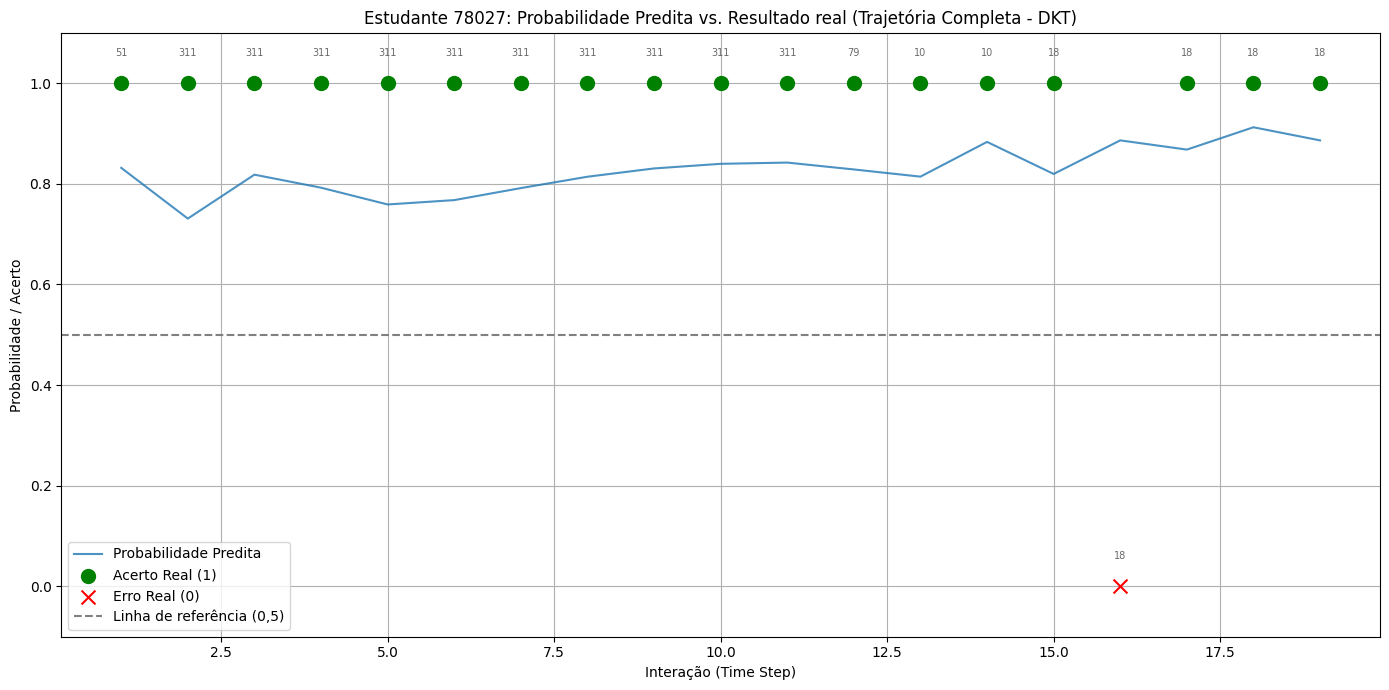

  Overall plot for Student 81656 saved to: /content/drive/MyDrive/Projeto Final - Introdução à Modelagem/Dataset/output/overall_trajectory_user_81656.png


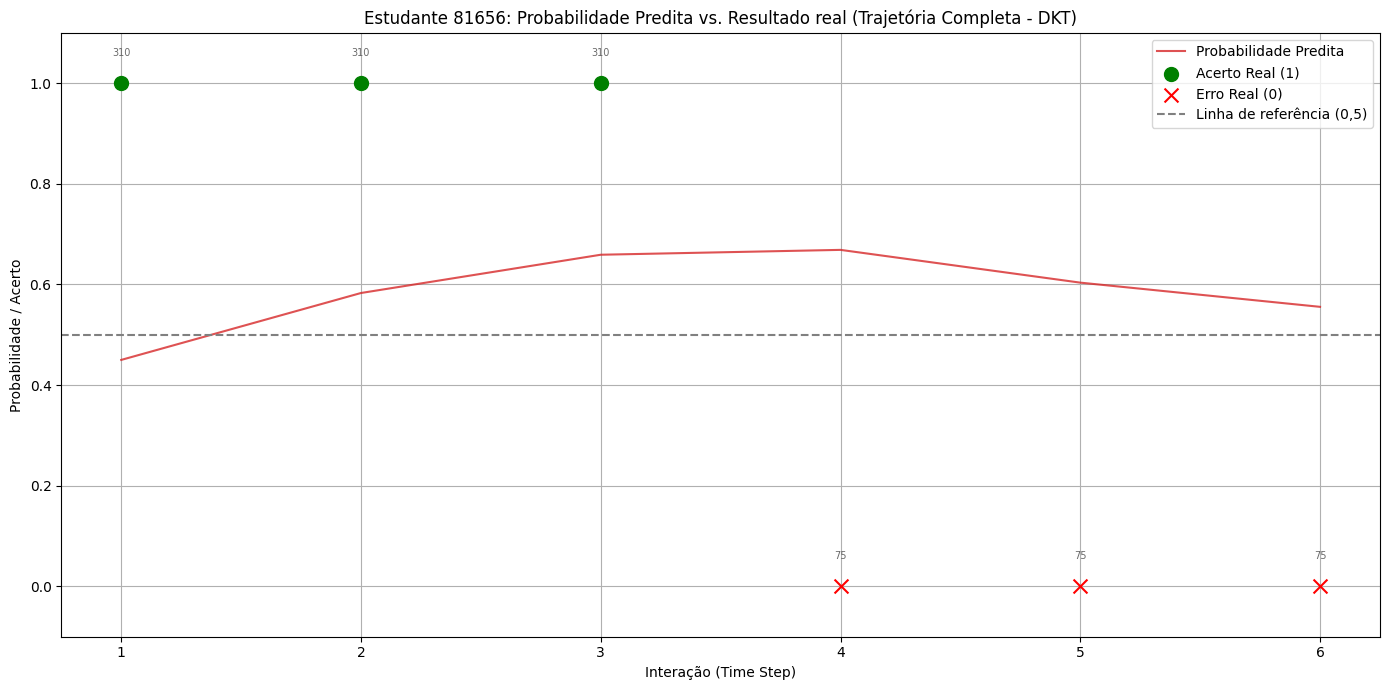

  Overall plot for Student 84760 saved to: /content/drive/MyDrive/Projeto Final - Introdução à Modelagem/Dataset/output/overall_trajectory_user_84760.png


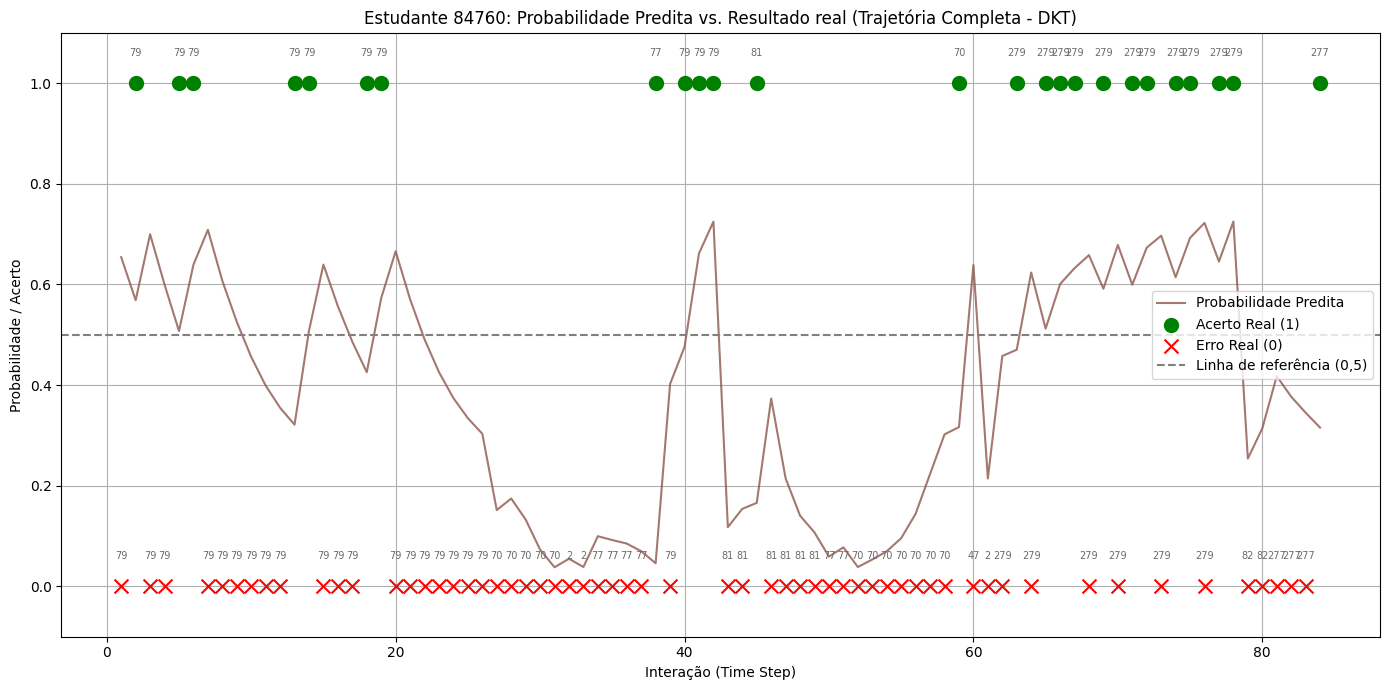


Finished generating overall student trajectory plots.

Generating Skill-Specific Trajectory Plots...
  Skill-specific plot for Student 84760.0, Skill 79 saved to: /content/drive/MyDrive/Projeto Final - Introdução à Modelagem/Dataset/output/skill_specific_trajectory_user_84760.0_skill_79_highlighted.png


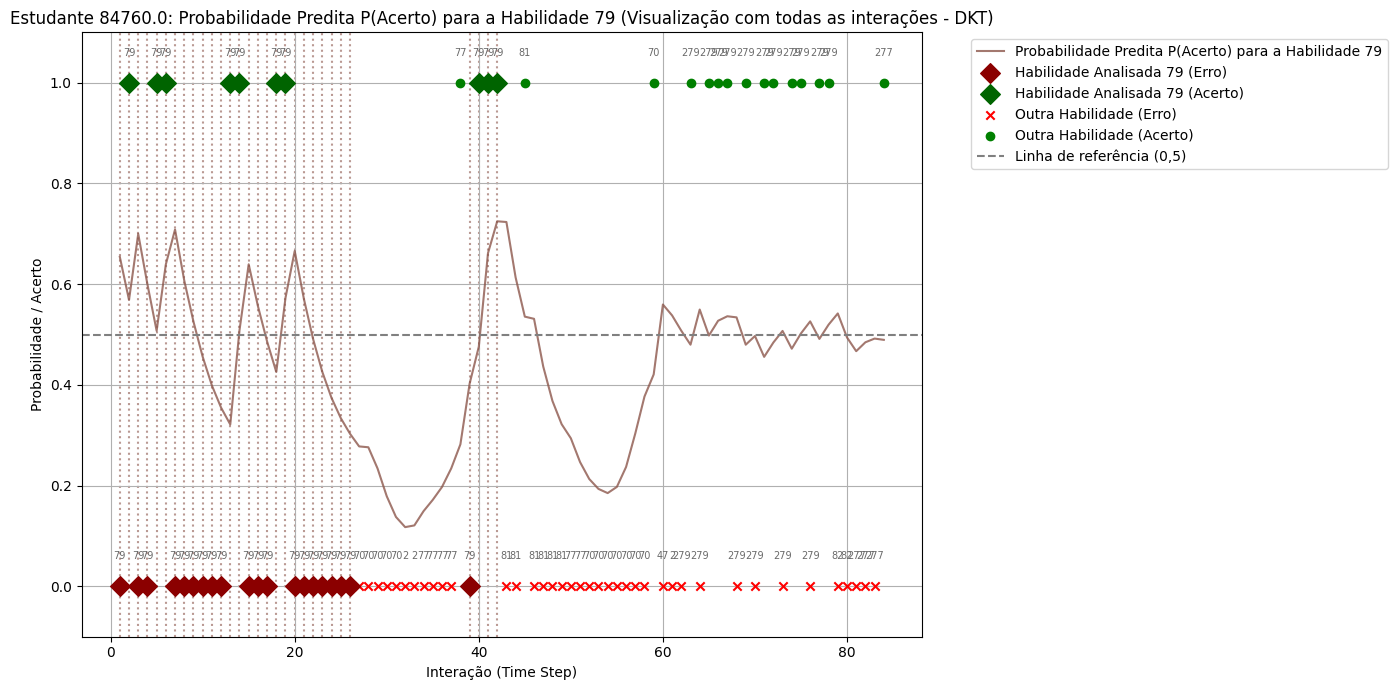

  Skill-specific plot for Student 81656.0, Skill 310 saved to: /content/drive/MyDrive/Projeto Final - Introdução à Modelagem/Dataset/output/skill_specific_trajectory_user_81656.0_skill_310_highlighted.png


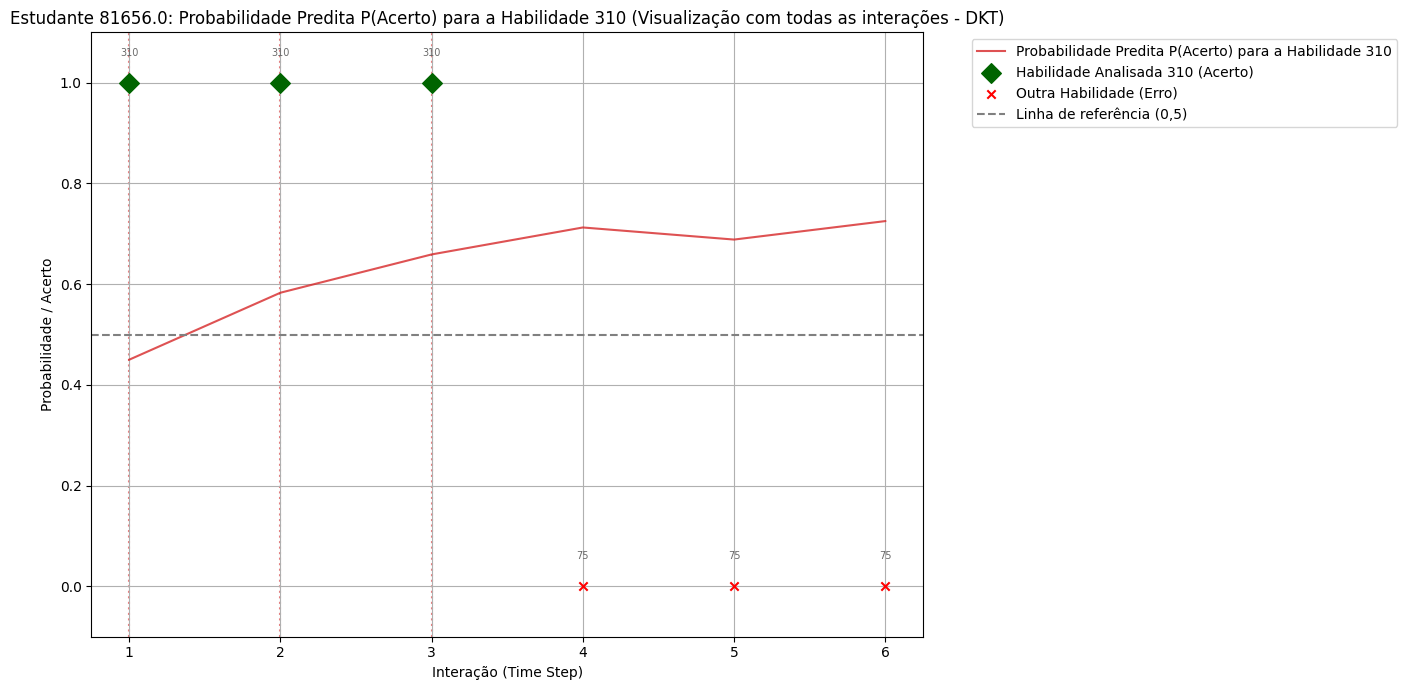

  Skill-specific plot for Student 78027.0, Skill 32 saved to: /content/drive/MyDrive/Projeto Final - Introdução à Modelagem/Dataset/output/skill_specific_trajectory_user_78027.0_skill_32_highlighted.png


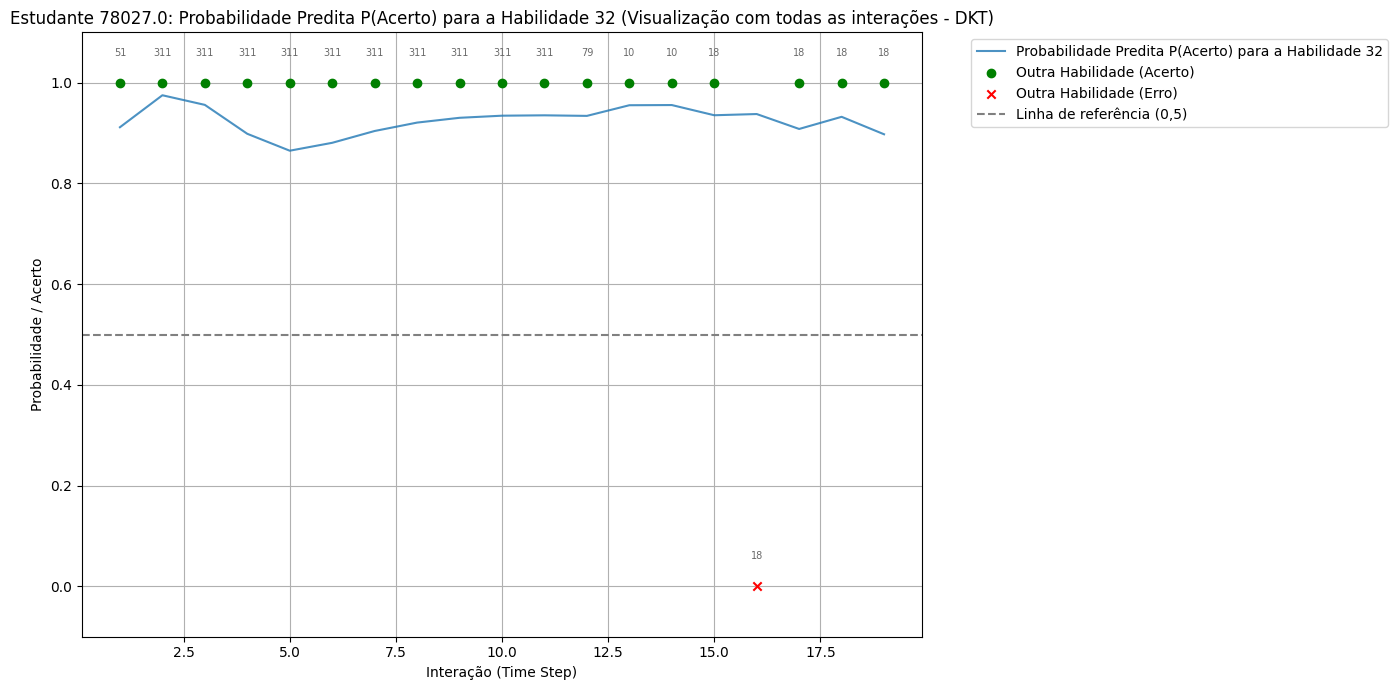


Finished generating skill-specific trajectory plots with highlighted target skill interactions.


In [ ]:
# Ensure model_perf is in evaluation mode and on the correct device
model_perf.eval()
model_perf.to(device)

# Get skill_idx_to_id_map
skill_idx_to_id_map = {idx: skill_id for skill_id, idx in skill_map.items()}

# --- Define the specific students and skills to plot---
requested_user_ids = [84760.0, 81656.0, 78027.0]

# Filter student_metrics_data to include only the requested students
specific_students_info = metrics_df[metrics_df['user_id'].isin(requested_user_ids)]

# --- Plot 1: Overall Student Trajectories (Predicted vs. Actual Correctness for all interactions) ---
print("\nGenerating Overall Student Trajectory Plots...")
for student_info in specific_students_info.itertuples():
    user_id = student_info.user_id
    original_seq_idx = int(student_info.original_idx)

    _, seq = student_sequences_with_ids[original_seq_idx]

    if len(seq) < 2:
        print(f"Skipping overall plot for student {user_id} due to short sequence length: {len(seq)}")
        continue

    single_student_dataset = DKTDataset([(user_id, seq)], M)
    x_single, q_next_single, a_next_single, _ = single_student_dataset[0]
    x_padded, q_next_padded, a_next_padded, mask_padded, _ = dkt_collate([(x_single, q_next_single, a_next_single, user_id)])

    x_padded = x_padded.to(device)
    q_next_padded = q_next_padded.to(device)
    a_next_padded = a_next_padded.to(device)
    mask_padded = mask_padded.to(device)

    with torch.no_grad():
        y_perf, _ = model_perf(x_padded)

    p_t_perf = y_perf.gather(2, q_next_padded.unsqueeze(-1)).squeeze(-1)

    valid_timesteps_mask = mask_padded.squeeze(0).bool().cpu().numpy()
    predicted_probs_filtered = p_t_perf.squeeze(0).cpu().numpy()[valid_timesteps_mask]
    actual_correctness_filtered = a_next_padded.squeeze(0).cpu().numpy()[valid_timesteps_mask]

    original_skill_ids_for_plot = [skill_idx_to_id_map[q_idx.item()] for q_idx in q_next_padded[0, valid_timesteps_mask]]

    interaction_numbers = np.arange(1, len(predicted_probs_filtered) + 1)

    plt.figure(figsize=(14, 7))
    plt.plot(interaction_numbers, predicted_probs_filtered, label="Probabilidade Predita", color=user_id_to_color_map[user_id], alpha=0.8)

    correct_mask = actual_correctness_filtered == 1
    incorrect_mask = actual_correctness_filtered == 0

    plt.scatter(interaction_numbers[correct_mask], actual_correctness_filtered[correct_mask],
                label="Acerto Real (1)", color='green', marker='o', s=100, zorder=5)
    plt.scatter(interaction_numbers[incorrect_mask], actual_correctness_filtered[incorrect_mask],
                label="Erro Real (0)", color='red', marker='x', s=100, zorder=5)

    plt.axhline(y=0.5, color='gray', linestyle='--', label='Linha de referência (0,5)')

    for k, (x_pos, y_pos) in enumerate(zip(interaction_numbers, actual_correctness_filtered)):
        plt.text(x_pos, y_pos + 0.05, str(original_skill_ids_for_plot[k]),
                 fontsize=7, ha='center', va='bottom', color='dimgray')

    plt.title(f"Estudante {user_id}: Probabilidade Predita vs. Resultado real (Trajetória Completa - DKT)")
    plt.xlabel("Interação (Time Step)")
    plt.ylabel("Probabilidade / Acerto")
    plt.legend()
    plt.grid(True)
    plt.ylim(-0.1, 1.1)
    plt.tight_layout()

    plot_filename_overall = os.path.join(output_path, f"overall_trajectory_user_{user_id}.png")
    plt.savefig(plot_filename_overall)
    print(f"  Overall plot for Student {user_id} saved to: {plot_filename_overall}")
    plt.show()
    plt.close()

print("\nFinished generating overall student trajectory plots.")

# --- Plot 2: Skill-Specific Trajectories (Predicted for specific skill vs. all interactions) ---
print("\nGenerating Skill-Specific Trajectory Plots...")

# Define user-skill pairs explicitly as requested by the user
# ADDED new user_id=78027.0 and skill_id=32
user_skill_pairs_to_plot = [
    (84760.0, 79),  # User 84760, Skill 79
    (81656.0, 310), # User 81656, Skill 310
    (78027.0, 32)   # NEW: User 78027, Skill 32
]

for target_user_id, target_skill_id in user_skill_pairs_to_plot:
    # Find the original_seq_idx for the target_user_id
    student_info = metrics_df[metrics_df['user_id'] == target_user_id].iloc[0]
    original_seq_idx = int(student_info.original_idx)

    _, seq = student_sequences_with_ids[original_seq_idx]

    if len(seq) < 2:
        print(f"Skipping skill-specific plot for student {target_user_id} due to short sequence length: {len(seq)}")
        continue

    # Convert target_skill_id to skill_idx
    target_skill_idx = skill_map[target_skill_id] # Assuming skill_map is available

    single_student_dataset = DKTDataset([(target_user_id, seq)], M)
    x_single, q_next_single, a_next_single, _ = single_student_dataset[0]
    x_padded, q_next_padded, a_next_padded, mask_padded, _ = dkt_collate([(x_single, q_next_single, a_next_single, target_user_id)])

    x_padded = x_padded.to(device)
    q_next_padded = q_next_padded.to(device)
    a_next_padded = a_next_padded.to(device)
    mask_padded = mask_padded.to(device)

    with torch.no_grad():
        y_perf, _ = model_perf(x_padded)

    actual_len = int(mask_padded.sum().item())

    # Predicted probabilities for the *specific target skill* across all time steps
    predicted_probs_for_target_skill_filtered = y_perf.squeeze(0)[:actual_len, target_skill_idx].cpu().numpy()
    time_steps = np.arange(1, actual_len + 1)

    # Actual interactions for marking
    q_next_np = q_next_padded.squeeze(0).cpu().numpy()
    a_next_np = a_next_padded.squeeze(0).cpu().numpy()

    plt.figure(figsize=(14, 7))
    plt.plot(time_steps, predicted_probs_for_target_skill_filtered,
             label=f'Probabilidade Predita P(Acerto) para a Habilidade {target_skill_id}',
             color=user_id_to_color_map[target_user_id], alpha=0.8)

    # Use a set to keep track of labels already added to the legend
    added_labels = set()

    # Mark interactions: clearly differentiate interactions with the target skill from other skills
    for t in range(actual_len):
        current_interaction_skill_idx = q_next_np[t] # The skill actually interacted with at time t
        current_interaction_skill_id = skill_idx_to_id_map[current_interaction_skill_idx]
        current_interaction_correctness = a_next_np[t]

        # Determine marker style and color
        if current_interaction_skill_id == target_skill_id: # Interaction with the specific skill we are tracking
            marker_color = 'darkgreen' if current_interaction_correctness == 1 else 'darkred'
            marker_style = 'D' # Diamond for target skill interaction
            markersize = 10
            zorder = 10
            plot_label_correct = f'Habilidade Analisada {target_skill_id} (Acerto)'
            plot_label_incorrect = f'Habilidade Analisada {target_skill_id} (Erro)'
            vertical_line_color = user_id_to_color_map[target_user_id] # Use student's color for vertical line
            plt.axvline(x=time_steps[t], color=vertical_line_color, linestyle=':', alpha=0.6, zorder=1) # Vertical line
        else: # Interaction with any other skill
            marker_color = 'green' if current_interaction_correctness == 1 else 'red'
            marker_style = 'o' if current_interaction_correctness == 1 else 'x' # Circle for correct, X for incorrect
            markersize = 6
            zorder = 5
            plot_label_correct = 'Outra Habilidade (Acerto)'
            plot_label_incorrect = 'Outra Habilidade (Erro)'

        current_label = plot_label_correct if current_interaction_correctness == 1 else plot_label_incorrect

        # Plot the marker for the actual correctness (0 or 1)
        if current_label not in added_labels:
            plt.scatter(time_steps[t], current_interaction_correctness,
                        color=marker_color, marker=marker_style, s=markersize**2, zorder=zorder,
                        label=current_label)
            added_labels.add(current_label)
        else:
            plt.scatter(time_steps[t], current_interaction_correctness,
                        color=marker_color, marker=marker_style, s=markersize**2, zorder=zorder)

        # Add skill labels at actual correctness points
        plt.text(time_steps[t], current_interaction_correctness + 0.05, # Position text above actual correctness point
                 str(current_interaction_skill_id),
                 fontsize=7, ha='center', va='bottom', color='dimgray')

    plt.axhline(y=0.5, color='gray', linestyle='--', label='Linha de referência (0,5)')

    plt.title(f"Estudante {target_user_id}: Probabilidade Predita P(Acerto) para a Habilidade {target_skill_id} (Visualização com todas as interações - DKT)")
    plt.xlabel("Interação (Time Step)")
    plt.ylabel("Probabilidade / Acerto")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside plot
    plt.grid(True)
    plt.ylim(-0.1, 1.1)
    plt.tight_layout()

    plot_filename_skill_specific = os.path.join(output_path, f"skill_specific_trajectory_user_{target_user_id}_skill_{target_skill_id}_highlighted.png")
    plt.savefig(plot_filename_skill_specific)
    print(f"  Skill-specific plot for Student {target_user_id}, Skill {target_skill_id} saved to: {plot_filename_skill_specific}")
    plt.show()
    plt.close()

print("\nFinished generating skill-specific trajectory plots with highlighted target skill interactions.")

## Seleção individual




Displaying plot for User ID 84760.0:


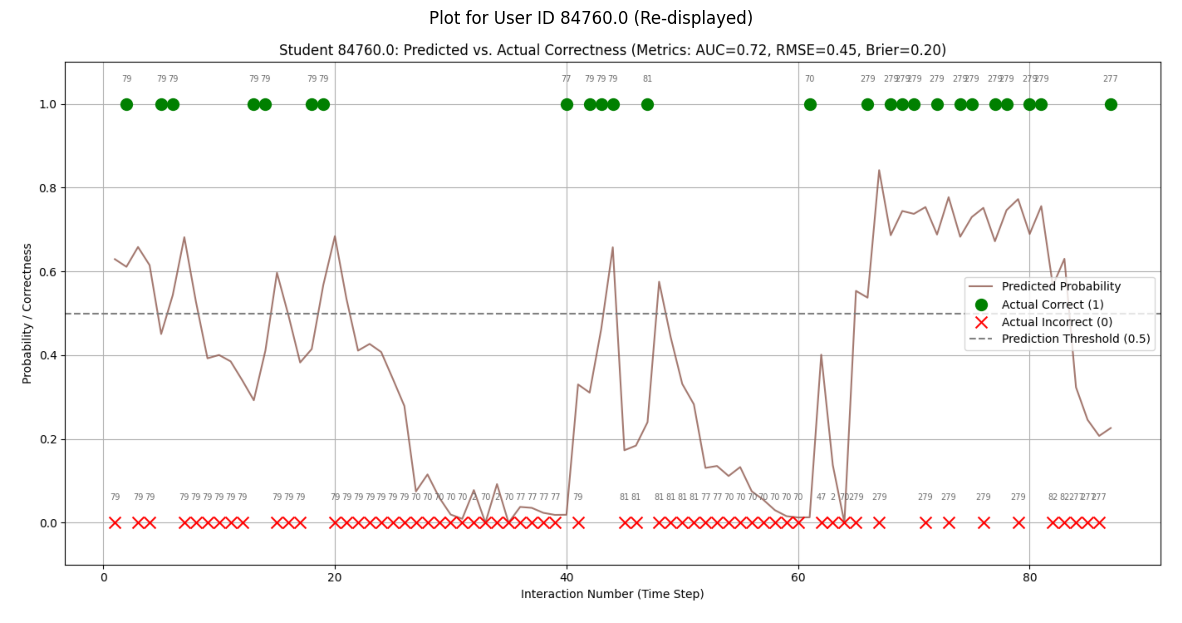

In [ ]:
''''
user_id_to_display = 84760.0
plot_filename = os.path.join(output_path, f"analysis_student_trajectory_perf_{user_id_to_display}_with_skills.png")

# Check if the file exists before attempting to display
if os.path.exists(plot_filename):
    print(f"Displaying plot for User ID {user_id_to_display}:")
    img = mpimg.imread(plot_filename)
    plt.figure(figsize=(15, 8)) # Adjust figure size for better visibility
    plt.imshow(img)
    plt.axis('off') # Hide axes
    plt.title(f"Plot for User ID {user_id_to_display}")
    plt.show()
else:
    print(f"Plot file not found for User ID {user_id_to_display} at: {plot_filename}")
    print("Please ensure that the plot was generated successfully in the previous steps.")'''